### Cella usa e getta (ogni volta che re-inizializzi il kernel)

In [1]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
#df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 44100

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open fil

TensorFlow version: 2.12.0
keras version = 2.12.0


# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [2]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 3.3 Autoencoder on preprocessed audio - Convolutional and flatten code

As we have seen before the MEL preprocessing is always beaten by one of the other two. For this reason we are going to avoid this type of computations and we will train the autoencoder to reconstruct the MFCC or the STFT only.

### Create the dataset

In [3]:
preprocessing = 'STFT'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing
train, val, test, INPUT_DIM = create_US_dataset(
        preprocessing=preprocessing,
        folder_number=1,
        main_dir = main_dir,
)

Creating the dataset from folder 01


In [4]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_STFT_count.txt with content '0' in folder Saved_Models


To interpret the mean squared error the we are going to optimize in our training we need to compute some mse between our images and some random images or between couple of images in our training set.

In [5]:
mse = tf.keras.losses.MeanSquaredError()

# Extract the first batch from the training set: x is a tuple of arrays of dim (128,220500)
for x, y in train.take(1):
    #compute the mse between the first batch and a batch of random images with the same shape
    random_images_1 = tf.random.uniform(shape=x.shape, minval = -1, maxval = 1,dtype=tf.float32)
    random_images_2 = np.random.uniform(-1, 1, size = x.shape)
    print(f'Mean MSE between an audio preprocessed and a random image (tf) : {mse(x, random_images_1):.5f}')
    print(f'Mean MSE between an audio preprocessed and a random image (np): {mse(x, random_images_2):.5f}')
    print(f'Mean MSE between two random images (tf-np): {mse(random_images_1, random_images_2):.5f}')

Mean MSE between an audio preprocessed and a random image (tf) : 0.97840
Mean MSE between an audio preprocessed and a random image (np): 0.97995
Mean MSE between two random images (tf-np): 0.66618


### Preparation to use Keras-Tuner

Now we define a function to build a generic convolutional autoencoder. We'll give this function to a keras tuner.

In [6]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [7]:
verbose = 0
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 3)
if verbose > 1:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)


Model built with 226403 trainable params


In [8]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp,test=False):

    #define hyperparameters
    if test: #if test is true you run the tuner only on a reduced hyperparameter space
        print('Running a test smaller grid search')
        n_units = 32
        n_layers = hp.Choice(name = 'n_layers', values =  [2,3])
        kernel_size = 3
        strides = 2
        max_pooling = 2
        regularizer = hp.Choice(name = 'regularizer', values = [1e-4,0.0])
        padding = 'same'
        code_size = 32
        activation = 'tanh'
        drop_out = hp.Choice(name = 'drop_out', values = [0.25,0.0])
        batch_norm = True
        lr_max, lr_min = 1e-3, 1e-3
        hp_lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    else:
        n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
        n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 3, step=1, sampling='linear', default = 2)
        kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
        strides = hp.Choice(name = 'strides', values = [2,3], default = 2)
        max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3], default = 2)
        regularizer = hp.Choice(name = 'regularizer', values = [0.0,1e-2,1e-3,1e-4,1e-5], default = 1e-4)
        padding = hp.Choice(name = 'padding', values = ['same','valid'], default = 'valid')
        code_size = hp.Choice(name = 'code_size', values = [32,64,128], default = 32)
        activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
        drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
        batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
        lr_min, lr_max =1e-4, 1e-1
        learning_rate= hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)


    model = build_autoencoder(code_size = code_size,
                              activation = activation,
                              padding = padding,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              regularizer = regularizer,
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [9]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 189795 trainable params
Model: "AE_Conv_prep_flatten_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                84768     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        105349    
                                                                 
Total params: 190,117
Trainable params: 189,795
Non-trainable params: 322
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [10]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 32,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'regularizer':0.0,
    'padding':'valid',
    'code_size':32,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
problematic_combination = []
max_model_size = 10**6
max_trials = 10
dir_name = AE_name
verbose=0

if strong_pc:
    train_small = train
    val_small = val
else:
    small_size_dataset = 40
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(10).batch(25)
    val_small = train_val_small.take(10).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}

#to be consistent with this type of grd search we should pass each hp more than one time...
for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        try:
            #create a tuner for the params not fixed
            tuner = build_tuner(build_model = build_model,
                                hpo_method = hpo_method,
                                max_model_size = max_model_size,
                                max_trials = max_trials,
                                dir_name = dir_name,
                                overwrite = True,
                                objective = kt.Objective('val_mse', direction='min'),
                                hp=hp,
                                not_fixed_param = hyper_params,
                                tune_new_entries=True
                                )

            if verbose>2:
                display(tuner.search_space_summary(extended = True))

            #fit the tuner
            epochs = 50
            patience = 10
            metrics = ['mse']
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                        verbose=verbose,
                                                        patience=patience)]

            tuner.search(train_small, validation_data = val_small,
                                callbacks=callbacks,
                                epochs=epochs,
                                verbose=int(verbose>0),
                        )

            #retrive the best value for the free hp
            best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

            #retrive the best score reached
            best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']

            print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
            best_score_dict[hpo_method].append(best_score)

            #update the default dict of values
            default_values[hyper_params] = best_value

            #save the updated dictionary
            file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
            with open(file_path, 'wb') as file:
                pickle.dump(default_values, file)

            #delete the folder just created by the run
            shutil.rmtree(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))

        except:
            problematic_combination.append(('search_for'+hyper_params, default_values))

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores'+preprocessing)
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)

display(problematic_combination)

Searching for the best value for strides
Using Random Search strategy for HPO
Model built with 189795 trainable params
Model built with 89955 trainable params
Model built with 189795 trainable params
Model built with 89955 trainable params
2/2 [==============================] - 1s 26ms/step - loss: 0.0404 - mse: 0.0404
The best value for strides is 3, the best score is 0.040382660925388336
Searching for the best value for n_layers
Using Random Search strategy for HPO
Model built with 89955 trainable params


Model built with 89955 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 155, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 146, in _build_hypermodel
    model = self.hypermodel.build

Model built with 481187 trainable params
Model built with 481187 trainable params
2/2 [==============================] - 1s 21ms/step - loss: 0.0257 - mse: 0.0257
The best value for n_layers is 1, the best score is 0.02569003589451313
Searching for the best value for regularizer
Using Random Search strategy for HPO
Model built with 481187 trainable params


Model built with 481187 trainable params
Model built with 481187 trainable params
Model built with 481187 trainable params
Model built with 481187 trainable params
Model built with 481187 trainable params
Model built with 481187 trainable params
2/2 [==============================] - 1s 17ms/step - loss: 0.0328 - mse: 0.0299
The best value for regularizer is 0.0001, the best score is 0.029922904446721077
Searching for the best value for n_units
Using Random Search strategy for HPO
Model built with 481187 trainable params


Model built with 481187 trainable params
Model built with 240611 trainable params
Model built with 962339 trainable params
Model built with 60179 trainable params
Model built with 1924643 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 1924643 parameters. Skip model.


Model built with 120323 trainable params
Model built with 240611 trainable params
2/2 [==============================] - 1s 30ms/step - loss: 0.0194 - mse: 0.0165
The best value for n_units is 16, the best score is 0.016494158655405045
Searching for the best value for batch_norm
Using Random Search strategy for HPO
Model built with 240611 trainable params


Model built with 240577 trainable params
Model built with 240611 trainable params
Model built with 240577 trainable params
2/2 [==============================] - 1s 36ms/step - loss: 0.0240 - mse: 0.0208
The best value for batch_norm is 0, the best score is 0.020755745470523834
Searching for the best value for kernel_size
Using Random Search strategy for HPO
Model built with 240577 trainable params


Model built with 219249 trainable params
Model built with 220017 trainable params
Model built with 240577 trainable params
Model built with 240577 trainable params
2/2 [==============================] - 1s 36ms/step - loss: 0.0239 - mse: 0.0207
The best value for kernel_size is 3, the best score is 0.020700862631201744
Searching for the best value for code_size
Using Random Search strategy for HPO
Model built with 240577 trainable params


Model built with 477153 trainable params
Model built with 950305 trainable params
Model built with 240577 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 40ms/step - loss: 0.0244 - mse: 0.0118
The best value for code_size is 128, the best score is 0.011767818592488766
Searching for the best value for activation
Using Random Search strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 54ms/step - loss: 0.0120 - mse: 0.0083
The best value for activation is elu, the best score is 0.00828343816101551
Searching for the best value for drop_out
Using Random Search strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 34ms/step - loss: 0.0108 - mse: 0.0077
The best value for drop_out is 0.0, the best score is 0.0077179670333862305
Searching for the best value for padding
Using Random Search strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 995537 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 21ms/step - loss: 0.0109 - mse: 0.0075
The best value for padding is valid, the best score is 0.0075172851793468
Searching for the best value for max_pooling
Using Random Search strategy for HPO
Model built with 950305 trainable params


Model built with 403409 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 20ms/step - loss: 0.0115 - mse: 0.0080
The best value for max_pooling is 2, the best score is 0.008038414642214775
Searching for the best value for learning_rate
Using Random Search strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 35ms/step - loss: 0.0092 - mse: 0.0070
The best value for learning_rate is 0.005, the best score is 0.007043787743896246


{'n_layers': 1,
 'n_units': 16,
 'kernel_size': 3,
 'strides': 3,
 'max_pooling': 2,
 'regularizer': 0.0001,
 'padding': 'valid',
 'code_size': 128,
 'activation': 'elu',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.005}

Searching for the best value for kernel_size
Using Bayesian Optimization strategy for HPO
Model built with 950305 trainable params


Model built with 864465 trainable params
Model built with 865233 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 25ms/step - loss: 0.0101 - mse: 0.0073
The best value for kernel_size is 3, the best score is 0.00728008383885026
Searching for the best value for max_pooling
Using Bayesian Optimization strategy for HPO
Model built with 950305 trainable params


Model built with 403409 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 24ms/step - loss: 0.0089 - mse: 0.0067
The best value for max_pooling is 2, the best score is 0.006678481586277485
Searching for the best value for activation
Using Bayesian Optimization strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 39ms/step - loss: 0.0106 - mse: 0.0076
The best value for activation is elu, the best score is 0.007573442999273539
Searching for the best value for drop_out
Using Bayesian Optimization strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 16ms/step - loss: 0.0082 - mse: 0.0064
The best value for drop_out is 0.5, the best score is 0.006430019624531269
Searching for the best value for batch_norm
Using Bayesian Optimization strategy for HPO
Model built with 950339 trainable params


Model built with 950305 trainable params
Model built with 950339 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 20ms/step - loss: 0.0092 - mse: 0.0071
The best value for batch_norm is 0, the best score is 0.007102870382368565
Searching for the best value for n_units
Using Bayesian Optimization strategy for HPO
Model built with 1900481 trainable params


Model built with 1900481 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 1900481 parameters. Skip model.


Model built with 950305 trainable params
Model built with 3800833 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 3800833 parameters. Skip model.


Model built with 237673 trainable params
Model built with 7601537 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 7601537 parameters. Skip model.


Model built with 475217 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 24ms/step - loss: 0.0084 - mse: 0.0065
The best value for n_units is 16, the best score is 0.0065096900798380375
Searching for the best value for learning_rate
Using Bayesian Optimization strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
Model built with 950305 trainable params
2/2 [==============================] - 1s 28ms/step - loss: 0.0084 - mse: 0.0065
The best value for learning_rate is 0.005, the best score is 0.006508006248623133
Searching for the best value for strides
Using Bayesian Optimization strategy for HPO
Model built with 2105777 trainable params


Model built with 950305 trainable params
Model built with 2105777 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 2105777 parameters. Skip model.


Model built with 950305 trainable params
2/2 [==============================] - 1s 29ms/step - loss: 0.0087 - mse: 0.0066
The best value for strides is 3, the best score is 0.006554693449288607
Searching for the best value for padding
Using Bayesian Optimization strategy for HPO
Model built with 950305 trainable params


Model built with 950305 trainable params
Model built with 995537 trainable params
Model built with 995537 trainable params
2/2 [==============================] - 1s 19ms/step - loss: 0.0092 - mse: 0.0068
The best value for padding is same, the best score is 0.006802832707762718
Searching for the best value for code_size
Using Bayesian Optimization strategy for HPO
Model built with 252017 trainable params


Model built with 499857 trainable params
Model built with 995537 trainable params
Model built with 252017 trainable params
Model built with 252017 trainable params
2/2 [==============================] - 1s 25ms/step - loss: 0.0079 - mse: 0.0065
The best value for code_size is 32, the best score is 0.006453223060816526
Searching for the best value for n_layers
Using Bayesian Optimization strategy for HPO
Model built with 31009 trainable params


Model built with 31009 trainable params
Model built with 56753 trainable params
Model built with 252017 trainable params
Model built with 252017 trainable params
2/2 [==============================] - 1s 36ms/step - loss: 0.0082 - mse: 0.0068
The best value for n_layers is 1, the best score is 0.006833570543676615
Searching for the best value for regularizer
Using Bayesian Optimization strategy for HPO
Model built with 252017 trainable params


Model built with 252017 trainable params
Model built with 252017 trainable params
Model built with 252017 trainable params
Model built with 252017 trainable params
Model built with 252017 trainable params
Model built with 252017 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 0.0065 - mse: 0.0065
The best value for regularizer is 0.0, the best score is 0.006500241346657276


{'n_layers': 1,
 'n_units': 16,
 'kernel_size': 3,
 'strides': 3,
 'max_pooling': 2,
 'regularizer': 0.0,
 'padding': 'same',
 'code_size': 32,
 'activation': 'elu',
 'drop_out': 0.5,
 'batch_norm': 0,
 'learning_rate': 0.005}

Searching for the best value for strides
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 252017 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 29ms/step - loss: 0.0418 - mse: 0.0418
The best value for strides is 2, the best score is 0.04183093085885048
Searching for the best value for n_layers
Using Hyperband strategy for HPO
Model built with 80929 trainable params


Model built with 80929 trainable params
Model built with 59873 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 23ms/step - loss: 0.0374 - mse: 0.0374
The best value for n_layers is 1, the best score is 0.0374346598982811
Searching for the best value for drop_out
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 37ms/step - loss: 0.0326 - mse: 0.0326
The best value for drop_out is 0.0, the best score is 0.032603614032268524
Searching for the best value for max_pooling
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 252017 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 22ms/step - loss: 0.0202 - mse: 0.0202
The best value for max_pooling is 2, the best score is 0.02018669620156288
Searching for the best value for learning_rate
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 39ms/step - loss: 0.0353 - mse: 0.0353
The best value for learning_rate is 0.001, the best score is 0.03531038016080856
Searching for the best value for kernel_size
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 533329 trainable params
Model built with 534097 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 25ms/step - loss: 0.0381 - mse: 0.0381
The best value for kernel_size is 3, the best score is 0.038135942071676254
Searching for the best value for padding
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 38ms/step - loss: 0.0377 - mse: 0.0377
The best value for padding is valid, the best score is 0.03768656775355339
Searching for the best value for code_size
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 1057137 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise error

Model built with 2105777 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise error

Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 22ms/step - loss: 0.0411 - mse: 0.0411
The best value for code_size is 32, the best score is 0.04109802469611168
Searching for the best value for regularizer
Using Hyperband strategy for HPO
Model built with 532817 trainable params


Model built with 532817 trainable params


Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
Model built with 532817 trainable params
2/2 [==============================] - 1s 35ms/step - loss: 0.0615 - mse: 0.0331
The best value for regularizer is 0.0001, the best score is 0.03314385935664177
Searching for the best value for n_units
Using Hyperband strategy for HPO
Model built with 1065601 trainable params


Model built with 1065601 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise error

Model built with 532817 trainable params
Model built with 2131169 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise error

Model built with 133229 trainable params
Model built with 4262305 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise error

Model built with 266425 trainable params
Model built with 266425 trainable params
2/2 [==============================] - 1s 21ms/step - loss: 0.0718 - mse: 0.0319
The best value for n_units is 8, the best score is 0.03186211735010147
Searching for the best value for batch_norm
Using Hyperband strategy for HPO
Model built with 266443 trainable params


Model built with 266425 trainable params
Model built with 266443 trainable params
Model built with 266425 trainable params
2/2 [==============================] - 1s 18ms/step - loss: 0.0986 - mse: 0.0813
The best value for batch_norm is 0, the best score is 0.08131857216358185
Searching for the best value for activation
Using Hyperband strategy for HPO
Model built with 266425 trainable params


Model built with 266425 trainable params
Model built with 266425 trainable params
Model built with 266425 trainable params
Model built with 266425 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 0.0701 - mse: 0.0435
The best value for activation is elu, the best score is 0.04350629076361656


{'n_layers': 1,
 'n_units': 8,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 2,
 'regularizer': 0.0001,
 'padding': 'valid',
 'code_size': 32,
 'activation': 'elu',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.001}

{'RandomSearch': [0.040382660925388336,
  0.02569003589451313,
  0.029922904446721077,
  0.016494158655405045,
  0.020755745470523834,
  0.020700862631201744,
  0.011767818592488766,
  0.00828343816101551,
  0.0077179670333862305,
  0.0075172851793468,
  0.008038414642214775,
  0.007043787743896246],
 'BayesianOptimization': [0.00728008383885026,
  0.006678481586277485,
  0.007573442999273539,
  0.006430019624531269,
  0.007102870382368565,
  0.0065096900798380375,
  0.006508006248623133,
  0.006554693449288607,
  0.006802832707762718,
  0.006453223060816526,
  0.006833570543676615,
  0.006500241346657276],
 'Hyperband': [0.04183093085885048,
  0.0374346598982811,
  0.032603614032268524,
  0.02018669620156288,
  0.03531038016080856,
  0.038135942071676254,
  0.03768656775355339,
  0.04109802469611168,
  0.03314385935664177,
  0.03186211735010147,
  0.08131857216358185,
  0.04350629076361656]}

[]

In [11]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,regularizer,padding,code_size,activation,drop_out,batch_norm,learning_rate
RandomSearch,1,16,3,3,2,0.0001,valid,128,elu,0.0,0,0.005
BayesianOptimization,1,16,3,3,2,0.0000,same,32,elu,0.5,0,0.005
Hyperband,1,8,3,2,2,0.0001,valid,32,elu,0.0,0,0.001


### Train the model with the best params on more data

In [15]:
insert_by_hand = True

if insert_by_hand:
    best_params = {
        'n_layers':1,
        'n_units':16,
        'kernel_size':3,
        'strides':3,
        'max_pooling':3,
        'regularizer':0.0001,
        'padding':'valid',
        'code_size':32,
        'activation':'elu',
        'drop_out':0.0,
        'batch_norm':False,
        'learning_rate':0.005,
    }
else:
    file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 1 if not strong_pc else 100
n_folders = 2 if not strong_pc else 125 #then you can restart and train on more folders

US_training(AE_name = AE_name, autoencoder = autoencoder, epochs = 100 , n_folders = 50 , preprocessing = preprocessing, ndim=3, verbose=verbose)

Model built with 102257 trainable params
Model: "AE_Conv_prep_flatten_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 4
Creating the dataset from folder 05


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 06


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 07


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 08


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 09


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 10


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 11


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 12


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 13


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 14


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 15


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 16


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 17


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 18


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 19


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 20


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 21


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 22


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 23


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 24


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 25


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 26


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 27


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 28


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 29


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 30


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 31


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 32


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 33


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 34


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 35


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 36


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 37


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 38


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 39


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 40


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 41


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 42


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 43


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 44


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 45


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 46


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 47


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 48


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 49


This model has a size of 1.2098770141601562 MB
Creating the dataset from folder 50


This model has a size of 1.2098770141601562 MB
This model has a size of 1.2098770141601562 MB


### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step


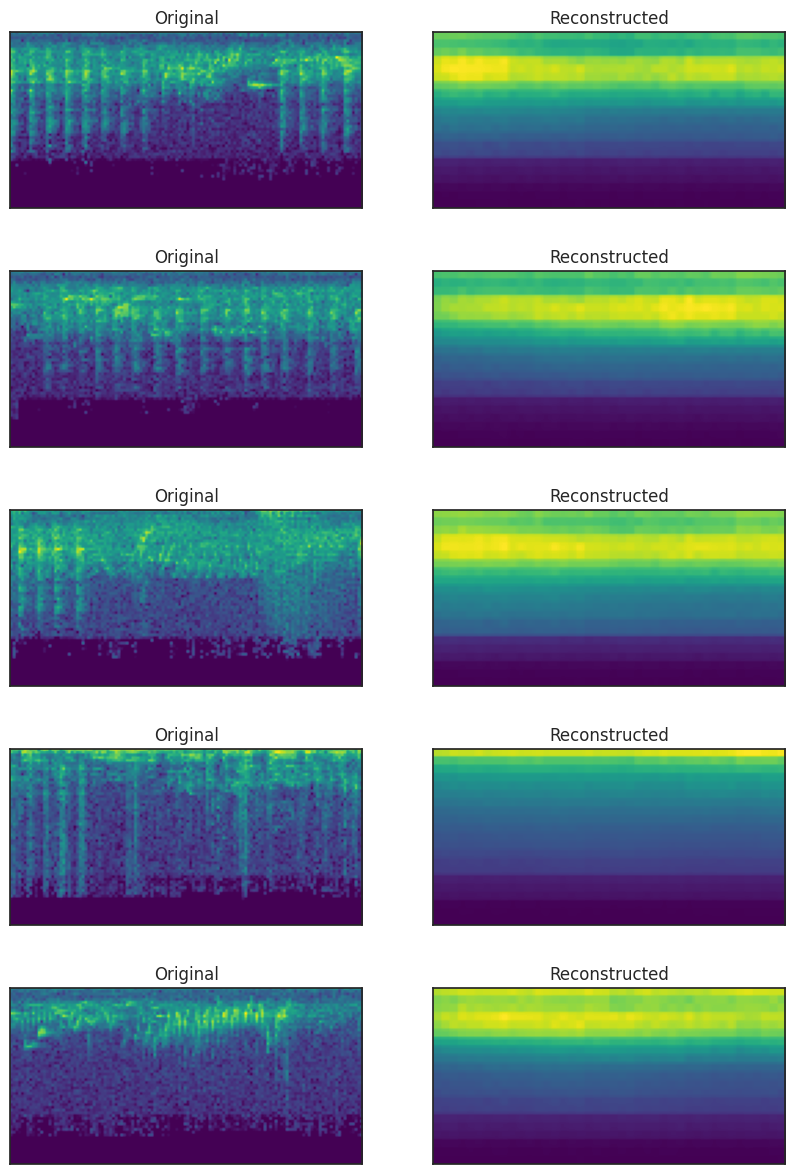

In [16]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Since there's less variability in the audio from unlabelled dataset we evaluate the autoencoder reconstruction on the labelled dataset.

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.
Model: "AE_Conv_prep_flatten_STFT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 20ms/step


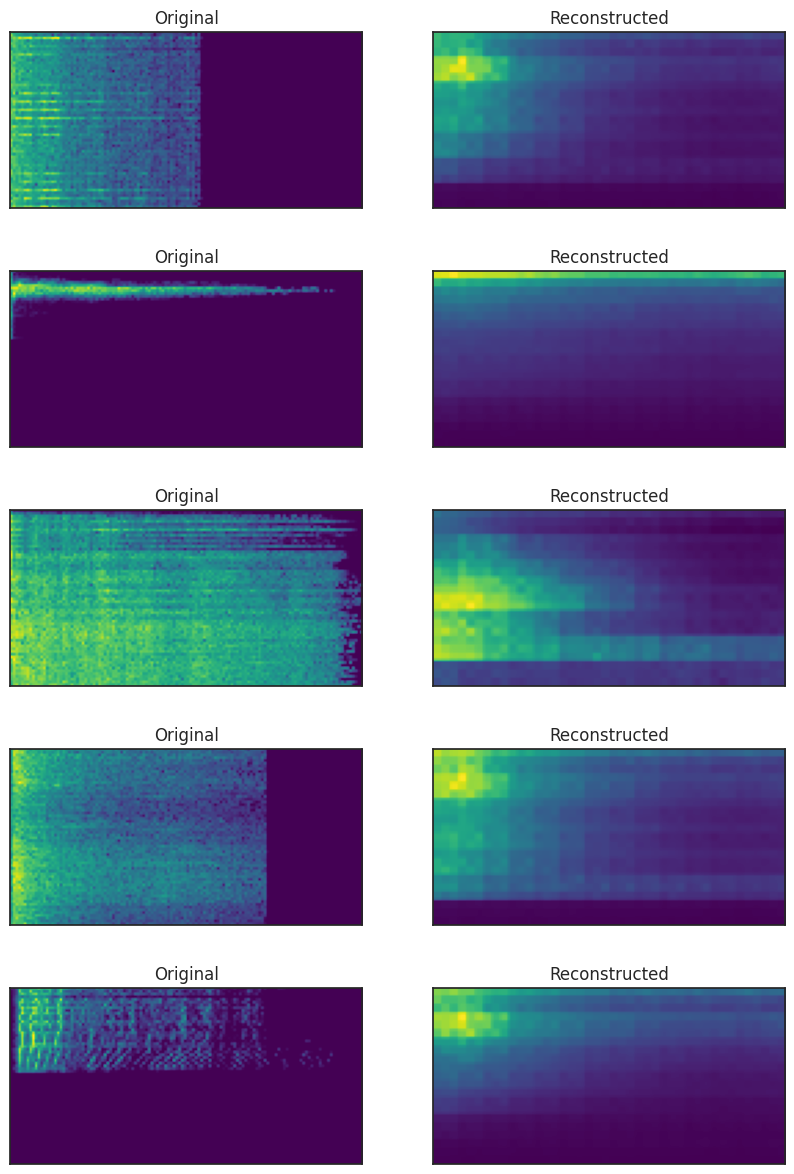

In [17]:
train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

### Plots of the latent space

Here we have to train an autoencoder with code size 2 or 3 just to plot the latent space. Clearly this is not optimal if you want to keep enoght information, but this is just for the sake of visualization.

#### Code size: 2 

In [3]:
preprocessing = 'STFT'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing+"_code_size_2"
train, val, test, INPUT_DIM = create_US_dataset(
        preprocessing=preprocessing,
        folder_number=1,
        main_dir = main_dir,
)

Creating the dataset from folder 01


2023-09-02 16:54:50.355377: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [68]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")

Created AE_Conv_prep_flatten_STFT_code_size_2_count.txt with content '0' in folder Saved_Models


In [69]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 2
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [70]:
insert_by_hand = True
strong_pc = False

if insert_by_hand:
    best_params = {
        'n_layers':1,
        'n_units':16,
        'kernel_size':3,
        'strides':3,
        'max_pooling':3,
        'regularizer':0.0001,
        'padding':'valid',
        'code_size':2,
        'activation':'elu',
        'drop_out':0.0,
        'batch_norm':False,
        'learning_rate':0.005,
    }
else:
    file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 100
n_folders = 50

US_training(AE_name = AE_name, autoencoder = autoencoder, epochs = epochs , n_folders = n_folders , preprocessing = preprocessing, ndim=3, verbose=verbose)

Model built with 8147 trainable params
Model: "AE_Conv_prep_flatten_STFT_code_size_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 2)                 3298      
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        4849      
                                                                 
Total params: 8,147
Trainable params: 8,147
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 0
Creating the dataset from folder 01


2023-09-01 18:36:19.328233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16]
	 [[{{node inputs}}]]
2023-09-01 18:36:19.334013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-01 18:36:19.372922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]
2023-09-01

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 02


2023-09-01 18:36:25.600262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16]
	 [[{{node inputs}}]]
2023-09-01 18:36:25.607701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-01 18:36:25.676621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]
2023-09-01

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 03


2023-09-01 18:36:31.457360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16]
	 [[{{node inputs}}]]
2023-09-01 18:36:31.463098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-01 18:36:31.503870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]
2023-09-01

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 04


2023-09-01 18:36:36.799436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16]
	 [[{{node inputs}}]]
2023-09-01 18:36:36.804452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-01 18:36:36.845316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]
2023-09-01

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 05


2023-09-01 18:36:42.823760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,16]
	 [[{{node inputs}}]]
2023-09-01 18:36:42.830293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-09-01 18:36:42.871893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1568]
	 [[{{node inputs}}]]
2023-09-01

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 06
You have just some of the files saved, not all of them
Proceding with normal dataset building.


2023-09-01 18:36:43.693753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:36:43.693857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:36:56.883652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 07


2023-09-01 18:37:21.317602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:37:21.317706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:37:34.270556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 08


2023-09-01 18:37:59.373190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:37:59.373306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:38:13.203110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 09


2023-09-01 18:38:39.996635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:38:39.996748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:38:53.730830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 10


2023-09-01 18:39:18.555295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:39:18.555401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:39:31.334313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 11


2023-09-01 18:39:55.559747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:39:55.559856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:40:08.427012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 12


2023-09-01 18:40:38.573951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:40:38.574060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:40:52.218426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 13


2023-09-01 18:41:15.888622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:41:15.888728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:41:28.848732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 14


2023-09-01 18:41:53.370908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:41:53.371014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:42:06.211983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 15


2023-09-01 18:42:30.594988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:42:30.595092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:42:43.504100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 16


2023-09-01 18:43:07.660347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:43:07.660456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:43:20.495938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 17


2023-09-01 18:43:44.437276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:43:44.437384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:43:57.240734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 18


2023-09-01 18:44:21.784549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:44:21.784658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:44:34.673701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 19


2023-09-01 18:44:59.934904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:44:59.935012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:45:13.934649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 20


2023-09-01 18:45:48.582752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:45:48.582860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:46:01.379760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 21


2023-09-01 18:46:25.885579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:46:25.885691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:46:39.283785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 22


2023-09-01 18:47:05.650519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:47:05.650624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:47:19.703521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 23


2023-09-01 18:47:46.563672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:47:46.563797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:48:00.980729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 24


2023-09-01 18:48:31.292951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:48:31.293059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:48:46.628446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 25


2023-09-01 18:49:16.022399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:49:16.022504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:49:29.855426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 26


2023-09-01 18:49:56.702323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:49:56.702428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:50:11.081818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 27


2023-09-01 18:50:40.205682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:50:40.205791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:50:54.454093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 28


2023-09-01 18:51:22.018571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:51:22.018691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:51:37.914070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 29


2023-09-01 18:52:07.394354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:52:07.394469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:52:22.269034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 30


2023-09-01 18:52:50.927149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:52:50.927258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:53:06.854186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 31


2023-09-01 18:53:36.991162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:53:36.991273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:53:52.282314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 32


2023-09-01 18:54:19.988808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:54:19.988939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:54:34.238234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 33


2023-09-01 18:55:00.994407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:55:00.994512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:55:14.974997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 34


2023-09-01 18:55:41.561057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:55:41.561179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:55:56.236749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 35


2023-09-01 18:56:22.196531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:56:22.196638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:56:35.657564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 36


2023-09-01 18:57:02.319357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:57:02.319465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:57:15.802027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 37


2023-09-01 18:57:42.114543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:57:42.114660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:57:55.968361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 38


2023-09-01 18:58:21.537185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:58:21.537293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:58:35.030725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 39


2023-09-01 18:59:00.699341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:59:00.699445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:59:14.187952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 40


2023-09-01 18:59:41.188898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:59:41.189007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 18:59:54.816296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 41


2023-09-01 19:00:22.608653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:00:22.608760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:00:36.749807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 42


2023-09-01 19:01:07.202528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:01:07.202646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:01:21.498051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 43


2023-09-01 19:01:47.563386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:01:47.563508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:02:01.209349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 44


2023-09-01 19:02:28.741458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:02:28.741565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:02:42.755642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 45


2023-09-01 19:03:07.938239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:03:07.938348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:03:21.646660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 46


2023-09-01 19:03:49.877870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:03:49.877988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:04:03.813207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 47


2023-09-01 19:04:29.237763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:04:29.237872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:04:44.559064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 48


2023-09-01 19:05:11.909850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:05:11.909961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:05:27.225355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 49


2023-09-01 19:05:55.152106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:05:55.152214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:06:10.157182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float
	 [[{{node Plac

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


Creating the dataset from folder 50


2023-09-01 19:06:39.917394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:06:39.917504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]
2023-09-01 19:06:54.913300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_code_size_2/assets


This model has a size of 0.1335601806640625 MB


In [4]:
from Visualization.model_plot import *

model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
encoder = model_loaded.layers[1]

In [5]:
preprocessing = 'STFT'
batch_size = 30
ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')

train, val, test, label = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = batch_size,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)

Found 400 files belonging to 10 classes.


Using 300 files for training.
Using 100 files for validation.


2023-09-02 16:55:10.748297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-09-02 16:55:10.748467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]


In [6]:

plot_latent_space(encoder, train, show_labels = {0:1, 1:0, 2:1}, numeric_labels = False, expected_shape = (1,64,128,1))


2023-09-02 16:55:13.178974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_40' with dtype resource
	 [[{{node Placeholder/_40}}]]
2023-09-02 16:55:13.179334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-09-02 16:55:14.657526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Plac

In [10]:
plot_latent_space(encoder, train, show_labels = {'sneezing':1, 'crackling_fire':1}, numeric_labels = False, expected_shape = (1,64,128,1))

2023-09-02 16:55:42.654952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float
	 [[{{node Placeholder/_22}}]]
2023-09-02 16:55:42.655353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-09-02 16:55:42.725562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeh

In [8]:
plot_latent_space(encoder, train, show_labels = 'all', numeric_labels = True, expected_shape = (1,64,128,1))

2023-09-02 16:55:15.499487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float
	 [[{{node Placeholder/_22}}]]
2023-09-02 16:55:15.499838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_40' with dtype resource
	 [[{{node Placeholder/_40}}]]
2023-09-02 16:55:15.564639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float
	 [[{{node Placeholder/_22}}]]
2023-09-02 16

In [9]:
plot_latent_space(encoder, train, show_labels = 'all', numeric_labels = False, expected_shape = (1,64,128,1))

2023-09-02 16:55:15.741993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [300]
	 [[{{node Placeholder/_0}}]]
2023-09-02 16:55:15.742592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_43' with dtype resource
	 [[{{node Placeholder/_43}}]]
2023-09-02 16:55:15.811034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_43' with dtype resource
	 [[{{node Placeholder/_43